In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv("Alcohol_Sales.csv", index_col="DATE", parse_dates=True)

In [4]:
data.columns = ["Sales"]
data.index.freq = 'MS'
data.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
X = []
Y = []
length = 12
for i in range(0,len(data)-length):
    X.append(data.iloc[i:i+length, 0])
    Y.append(data.iloc[i+length, 0])
X = np.array(X)
Y = np.array(Y)   

In [6]:
N_test = 24
X_train, Y_train = X[:-N_test], Y[:-N_test]
X_test, Y_test = X[-N_test:], Y[-N_test:]

In [7]:
X_train.shape

(289, 12)

In [8]:
train_idx = data.index < data.index[-N_test]
test_idx = ~train_idx

train_idx[:length] = False # first 12 values are not predictable

In [9]:
np.sum(train_idx)

289

## Linear Regression

In [10]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
np.linalg.norm(lr.coef_)

0.9604174733819439

In [11]:
lr.score(X_test, Y_test)

0.8744715839900723

RMSE

In [12]:
mean_squared_error(Y_test, lr.predict(X_test), squared=False)

541.3927693727626

In [13]:
data.loc[train_idx, "LinReg_train"] = lr.predict(X_train)
data.loc[test_idx, "LinReg_test"] = lr.predict(X_test)

<AxesSubplot:xlabel='DATE'>

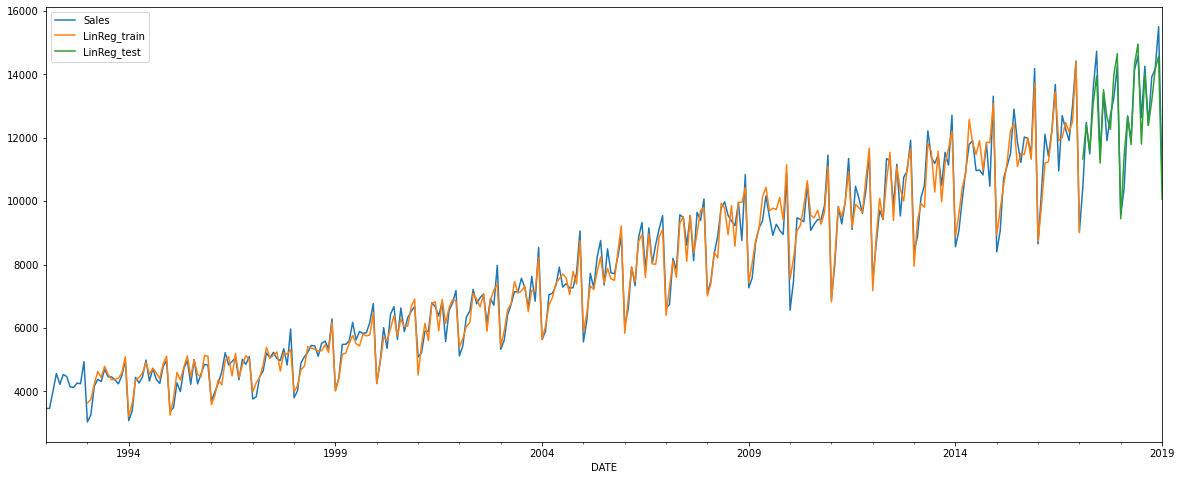

In [14]:
data[["Sales", "LinReg_train", "LinReg_test"]].plot(figsize=(20,8))

## Ridge and Lasso

In [15]:
ridge = linear_model.Ridge(alpha=.5)
ridge.fit(X_train, Y_train)
np.linalg.norm(ridge.coef_)

0.9604174712620195

In [16]:
ridge.score(X_test, Y_test)

0.8744715840203687

In [17]:
mean_squared_error(Y_test, ridge.predict(X_test), squared=False)

541.3927693074297

In [18]:
lasso = linear_model.Ridge(alpha=.5)
lasso.fit(X_train, Y_train)
np.linalg.norm(lasso.coef_)

0.9604174712620195

In [19]:
lasso.score(X_test, Y_test)

0.8744715840203687

In [20]:
mean_squared_error(Y_test, lasso.predict(X_test), squared=False)

541.3927693074297

## Gaussian Process

In [21]:
gpr = GaussianProcessRegressor(kernel = RBF(length_scale=0.5 ,length_scale_bounds="fixed"))
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=0.5))

In [22]:
gpr.score(X_test, Y_test)

-69.87834933181139

In [23]:
mean_squared_error(Y_test, gpr.predict(X_test), squared=False)

12864.65737981389

In [24]:
data.loc[train_idx, "Gpr_train"] = gpr.predict(X_train)
data.loc[test_idx, "Gpr_test"] = gpr.predict(X_test)

<AxesSubplot:xlabel='DATE'>

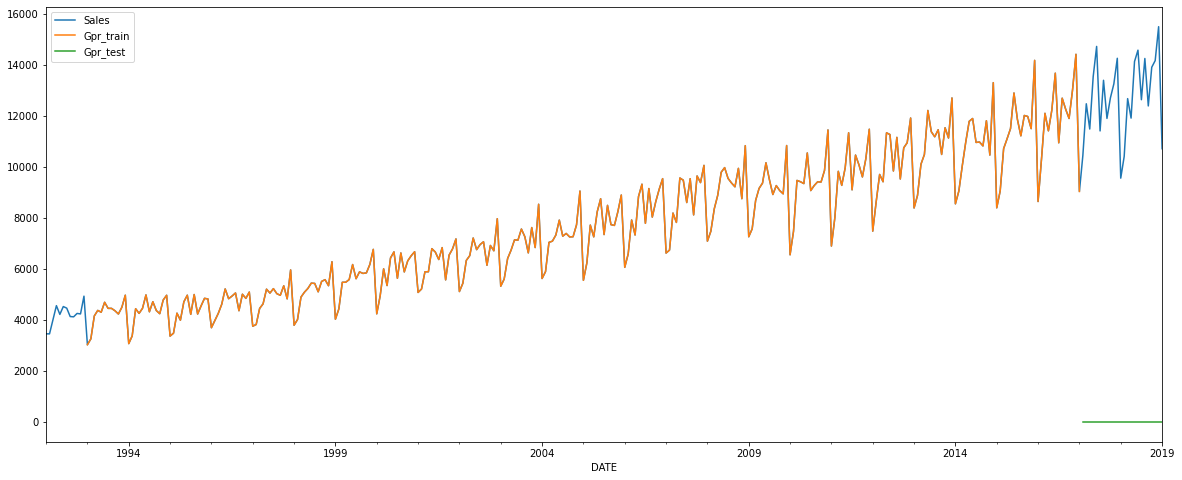

In [25]:
data[["Sales", "Gpr_train", "Gpr_test"]].plot(figsize=(20,8))

## Random Forest

In [26]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200)

In [27]:
rf.score(X_test, Y_test)

0.7352594767657834

In [28]:
mean_squared_error(Y_test, rf.predict(X_test), squared=False)

786.233670017222

In [29]:
data.loc[train_idx, "Rf_train"] = rf.predict(X_train)
data.loc[test_idx, "Rf_test"] = rf.predict(X_test)

<AxesSubplot:xlabel='DATE'>

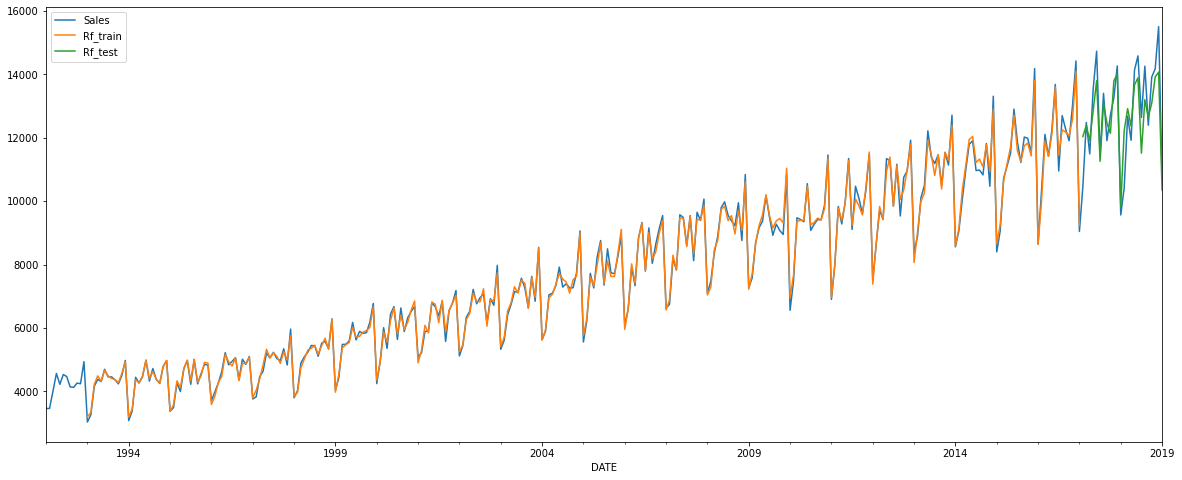

In [30]:
data[["Sales", "Rf_train", "Rf_test"]].plot(figsize=(20,8))

## Multilayer Perceptron

In [31]:
mlp = MLPRegressor(hidden_layer_sizes=(100,))
mlp.fit(X_train, Y_train)

C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [32]:
mlp.score(X_test, Y_test)

0.6733119093374521

In [33]:
mean_squared_error(Y_test, mlp.predict(X_test), squared=False)

873.3897246856169

In [34]:
data.loc[train_idx, "Mlp_train"] = rf.predict(X_train)
data.loc[test_idx, "Mlp_test"] = rf.predict(X_test)

<AxesSubplot:xlabel='DATE'>

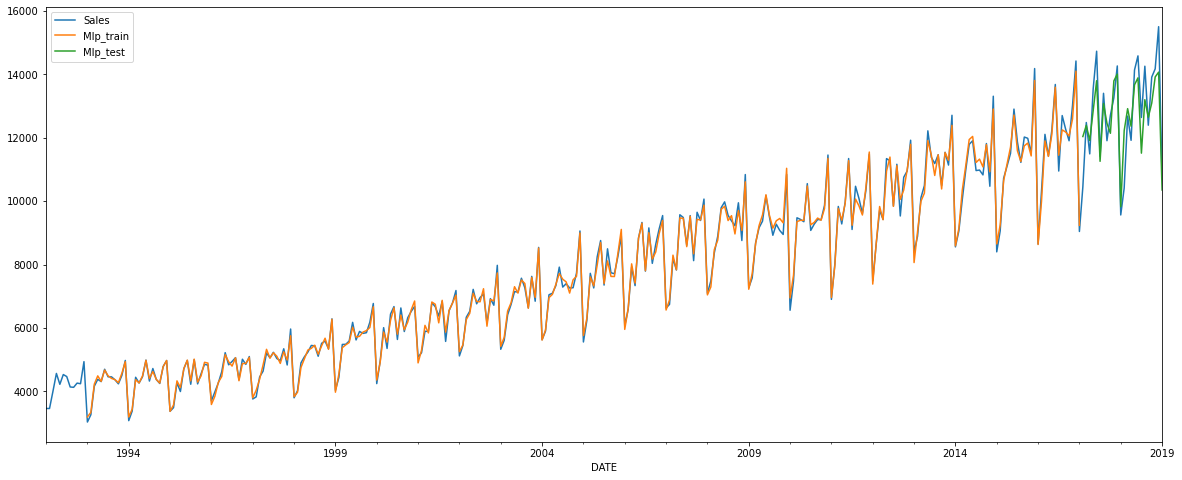

In [35]:
data[["Sales", "Mlp_train", "Mlp_test"]].plot(figsize=(20,8))

# Optimize the models

## Gaussian Process

Why does the Gaussian Process Regressor perform so badly?

In [179]:
gpr = GaussianProcessRegressor(kernel = RBF(length_scale=0.5, length_scale_bounds="fixed"))
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=0.5))

In [180]:
gpr.score(X_test, Y_test)

-69.87834933181139

In [181]:
mean_squared_error(Y_test, gpr.predict(X_test), squared=False)

12864.65737981389

Use Grid Search to find the optimal hyperparameters

In [39]:
gpr = GaussianProcessRegressor(kernel = RBF(length_scale_bounds="fixed"))

In [40]:
parameters = {'kernel__length_scale':[1e+5, 1e+6, 1e+7]}
clf = GridSearchCV(gpr, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(estimator=GaussianProcessRegressor(kernel=RBF(length_scale=1)),
             param_grid={'kernel__length_scale': [100000.0, 1000000.0,
                                                  10000000.0]})

In [41]:
clf.cv_results_

{'mean_fit_time': array([0.00400009, 0.00440044, 0.00519814]),
 'std_fit_time': array([0.00126667, 0.00120093, 0.00116559]),
 'mean_score_time': array([0.00139995, 0.00180044, 0.00180144]),
 'std_score_time': array([0.00048983, 0.00039931, 0.00074927]),
 'param_kernel__length_scale': masked_array(data=[100000.0, 1000000.0, 10000000.0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel__length_scale': 100000.0},
  {'kernel__length_scale': 1000000.0},
  {'kernel__length_scale': 10000000.0}],
 'split0_test_score': array([0.59104204, 0.6904566 , 0.72354136]),
 'split1_test_score': array([0.91589038, 0.91362233, 0.87938437]),
 'split2_test_score': array([0.84431749, 0.94559986, 0.91264909]),
 'split3_test_score': array([0.72146668, 0.87618279, 0.82116104]),
 'split4_test_score': array([-0.33799288,  0.78919297,  0.85634748]),
 'mean_test_score': array([0.54694474, 0.84301091, 0.83861667]),
 'std_test_score': array([0.45608519,

In [42]:
clf.best_params_

{'kernel__length_scale': 1000000.0}

In [43]:
clf.best_estimator_.score(X_test, Y_test)

0.9244523435172279

## Random Forest

In [49]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=1000)

In [45]:
rf.score(X_test, Y_test)

0.720462147755214

In [46]:
mean_squared_error(Y_test, rf.predict(X_test), squared=False)

807.9076843283983

Optimize the tree parameters

In [50]:
rf = RandomForestRegressor(n_estimators=1000)

In [51]:
parameters = {'max_depth':[6, 8, 10], 'min_samples_split':[2, 3]}
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000),
             param_grid={'max_depth': [6, 8, 10], 'min_samples_split': [2, 3]})

In [52]:
clf.best_params_

{'max_depth': 8, 'min_samples_split': 2}

In [53]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=8)
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)

0.734906349868581

## Multilayer Perceptron

In [195]:
mlp = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, solver='lbfgs', verbose=True, random_state=42)
mlp.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [203]:
parameters = {'alpha':(10.0 ** -np.arange(1, 7))}
clf = GridSearchCV(mlp, parameters)
clf.fit(X_train, Y_train)

C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

GridSearchCV(estimator=MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000,
                                    solver='lbfgs', verbose=True),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])})

In [204]:
clf.best_params_

{'alpha': 0.1}

In [205]:
mlp = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, solver='lbfgs', alpha=1e-01, verbose=True)
mlp.fit(X_train, Y_train)

C:\Users\atace\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.1, hidden_layer_sizes=(500,), max_iter=1000,
             solver='lbfgs', verbose=True)

In [206]:
mlp.score(X_test, Y_test)

0.9568710494166793

In [207]:
mean_squared_error(Y_test, mlp.predict(X_test), squared=False)

317.34077086304427

In [208]:
data.loc[train_idx, "Best_train"] = mlp.predict(X_train)
data.loc[test_idx, "Best_test"] = mlp.predict(X_test)

<AxesSubplot:xlabel='DATE'>

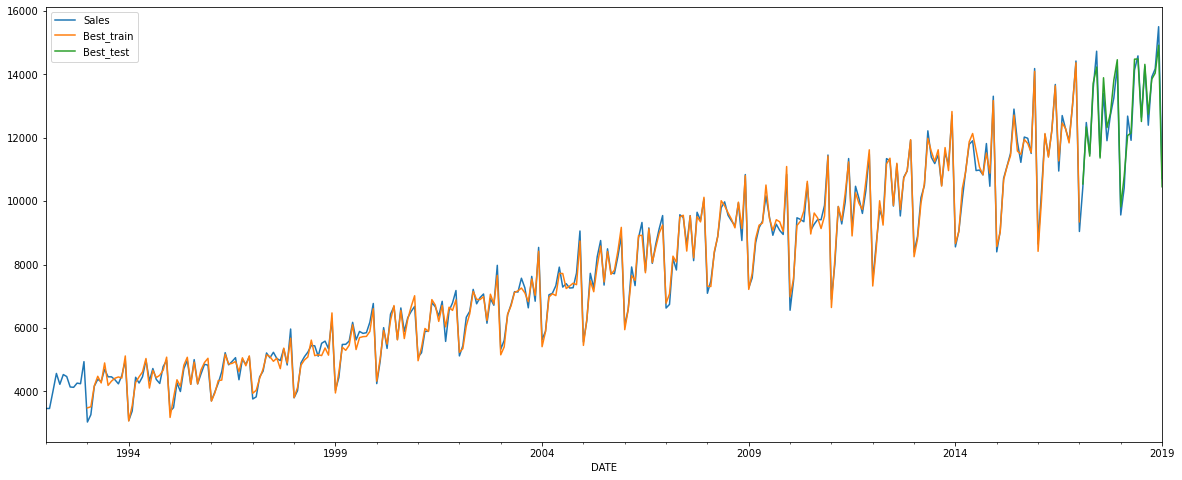

In [209]:
data[["Sales", "Best_train", "Best_test"]].plot(figsize=(20,8))

# Bayesian Optimization and XGBRegressor

In [219]:
from skopt import gp_minimize
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [364]:
def objective(params):
    xgb = XGBRegressor( n_estimators = 300,
                        max_depth = params[0],
                        random_state = 42,
                        n_jobs = -1)
    return -np.mean(cross_val_score(xgb, X_train, Y_train, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error'))

In [365]:
space = [
    (2, 16)
]

r = gp_minimize(objective, space, n_calls=50, random_state=42, verbose=True)
print(r.x)
best_params = r.x
print(r.fun)
result = r.fun

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.7207
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2252
Function value obtained: 702.4462
Current minimum: 652.2535
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7883
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.6792
Function value obtained: 657.2172
Current minimum: 652.2535
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.2910
Function value obtained: 668.8808
Current minimum: 652.2535
Iteration No: 6

C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 1.9476
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 12 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 1.8569
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 13 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.9710
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 14 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.0094
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 15 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.5654
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 16 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.9640
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 17 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.9074
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 18 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.8296
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 19 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.9889
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 20 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 3.0633
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 21 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.8022
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 22 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.2462
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 23 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 4.4347
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 24 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.0914
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 25 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.4940
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 26 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.6951
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 27 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.6038
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 28 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.7323
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 29 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 4.2095
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 30 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 4.6851
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 31 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 4.1681
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 32 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.9022
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 33 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.2933
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 34 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 4.5812
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 35 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 4.7385
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 36 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 4.1664
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 37 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 3.9215
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 38 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 3.8975
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 39 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 3.6524
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 40 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 4.0471
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 41 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 4.2880
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 42 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.9866
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 43 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 4.6312
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 44 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 4.2939
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 45 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 4.6811
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 46 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 4.4422
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 47 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 3.8301
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 48 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 4.1369
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 49 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 4.1431
Function value obtained: 652.2535
Current minimum: 652.2535
Iteration No: 50 started. Searching for the next optimal point.


C:\Users\atace\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 5.3639
Function value obtained: 652.2535
Current minimum: 652.2535
[13]
652.2535374574069


In [359]:
xgb = XGBRegressor( n_estimators = 300,
                    tree_method = 'exact',
                    max_depth = 12,
                    random_state = 42,
                    n_jobs = -1)

In [360]:
xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [361]:
xgb.score(X_test, Y_test)

0.8099512699108007

In [362]:
mean_squared_error(Y_test, xgb.predict(X_test), squared=False)

666.1528846413654

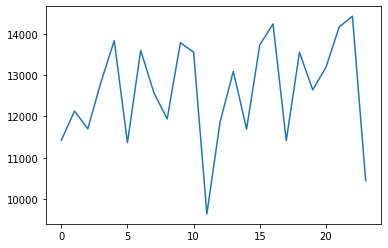

In [352]:
plt.plot(xgb.predict(X_test))